In [1]:
%matplotlib inline

In [2]:
import brightway2 as bw
import wurst as w
import matplotlib.pyplot as plt
import pyprind
import numpy as np
import pandas as pd

In [3]:
if pd.__version__ < '0.22':
    print("Please update Pandas: conda upgrade pandas")

# Basic setup

In [4]:
bw.projects.set_current("manipulation blog post notebook")

In [4]:
assert "biosphere3" in bw.databases, "Please run `bw2setup`"
assert "ecoinvent 3.4 cutoff" in bw.databases, "Please import ecoinvent"

In [9]:
recipe = ('ReCiPe Endpoint (H,A)', 'total', 'total')
ipcc = ('IPCC 2013', 'climate change', 'GWP 100a')

# Check on impact of electricity generation

We can do this most easily by deleting direct electricity inputs. Simple!

Extract `ecoinvent` using Wurst to make manipulation easier.

In [10]:
ecoinvent = w.brightway.extract_brightway2_databases(["ecoinvent 3.4 cutoff"])

Getting activity data


  0%|          | 2296/520205 [00:00<00:22, 22952.42it/s]

Adding exchange data to activities


100%|██████████| 520205/520205 [00:36<00:00, 14316.51it/s]


Filling out exchange data


100%|██████████| 14889/14889 [00:02<00:00, 5562.29it/s]


Check to make sure that `kilowatt hour` is always electricity.

In [12]:
{exc['product'] for ds in ecoinvent for exc in ds['exchanges'] if exc['unit'] == 'kilowatt hour'}

{'electricity, for reuse in municipal waste incineration only',
 'electricity, high voltage',
 'electricity, high voltage, aluminium industry',
 'electricity, high voltage, for Swiss Federal Railways',
 'electricity, high voltage, for internal use in coal mining',
 'electricity, high voltage, label-certified',
 'electricity, low voltage',
 'electricity, low voltage, label-certified',
 'electricity, medium voltage',
 'electricity, medium voltage, aluminium industry',
 'electricity, medium voltage, label-certified'}

While we are at it, might as well check to make sure there is no electricity with different units

In [13]:
{exc['product'] for ds in ecoinvent for exc in ds['exchanges'] 
 if exc['unit'] != 'kilowatt hour' and 'electricity' in str(exc['product'])}

{'distribution network, electricity, low voltage',
 'energy use and operation emissions, electric bicycle, label-certified electricity',
 'foam glass, electricity, label-certified',
 'heat and power co-generation unit, 160kW electrical, common components for heat+electricity',
 'heat and power co-generation unit, 160kW electrical, components for electricity only',
 'heat and power co-generation unit, 1MW electrical, common components for heat+electricity',
 'heat and power co-generation unit, 1MW electrical, components for electricity only',
 'heat and power co-generation unit, 200kW electrical, common components for heat+electricity',
 'heat and power co-generation unit, 200kW electrical, components for electricity only',
 'heat and power co-generation unit, 200kW electrical, diesel SCR, common components for heat+electricity',
 'heat and power co-generation unit, 200kW electrical, diesel SCR, components for electricity only',
 'heat and power co-generation unit, 500kW electrical, com

OK. So,all we need to do is set every exchange that consumes electricity (i.e. has units of `kilowatt hour`) to zero; then the impact of electricity will be the total impact minus the impact in our modified database.

In [14]:
kwh = w.equals("unit", "kilowatt hour")

for dataset in ecoinvent:
    for exchange in w.technosphere(dataset, kwh):
        exchange['amount'] = 0

Write the modified database

In [15]:
w.brightway.write_brightway2_database(ecoinvent, "3.4 no electricity")

14889 datasets
520205 exchanges
0 unlinked exchanges
  


Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:01:08


Title: Writing activities to SQLite3 database:
  Started: 02/20/2018 10:00:18
  Finished: 02/20/2018 10:01:26
  Total time elapsed: 00:01:08
  CPU %: 93.90
  Memory %: 23.04
Created database: 3.4 no electricity


## Graph the difference between original and modified databases

In [16]:
def graph(data, title):
    data = np.array(data)
    data = data[data >= 0]
    data = data[data <= 1]
    with plt.style.context("fast"):
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax2 = ax1.twiny()

        ax1.hist(data, bins=50, alpha=0.5)

        ax2 = ax1.twinx()
        ys = np.linspace(1, 0, len(data))
        xs = sorted(data, reverse=True)
        ax2.plot(xs, ys, 'g', lw=2)
        ax2.set_ylim((0, 1))
        ax2.set_ylabel("Cumulative fraction")
        ax1.set_ylabel("Number of datasets per bin")
        ax1.set_xlabel("{}\nAverage: {:.2f}".format(title, np.average(data)))
        
        ax1.grid()
        plt.xlim(0, 1)

        plt.tight_layout()
        plt.savefig(title + ".png", dpi=300)   

In [17]:
def scores_for_db(db, method):
    lca = bw.LCA({bw.Database(db).random(): 1}, method)
    lca.lci()
    lca.lcia()        

    results = {}
    for ds in pyprind.prog_bar(bw.Database(db)):
        lca.redo_lcia({ds: 1})
        results[ds['code']] = abs(lca.score)

    return results

In [20]:
full = scores_for_db("ecoinvent 3.4 cutoff", recipe)
electricity = scores_for_db("3.4 no electricity", recipe)

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:02:55
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:02:51


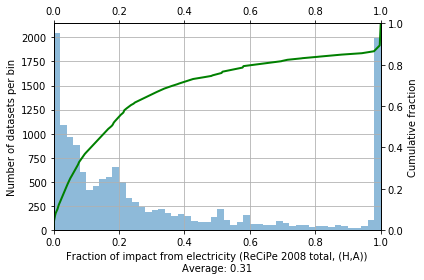

In [22]:
graph(
    [1 - (electricity[code] / (full[code] or 1)) for code in full],
    "Fraction of impact from electricity (ReCiPe 2008 total, (H,A))"    
)

# Emissions by location

## Get a dataframe for results by activity

This is pretty eaasy, just sum the `characterized_inventory` matrix (flows by activities) to get cumulative score by activity.

In [8]:
import brightway2 as bw
import pandas as pd

def dataframe_by_activity(activity, method):
    lca = bw.LCA({activity: 1}, method=method)
    lca.lci()
    lca.lcia()
    activity_scores = lca.characterized_inventory.sum(axis=0)  # 0 is the first dimension, i.e. biosphere flows
    df = pd.DataFrame.from_dict([
            {
                'location': a['location'],
                'score': activity_scores[0, lca.activity_dict[a]]  # 0 because there is only one row in this matrix
            } 
        for a in bw.Database(activity['database']) 
        # Skip activities with no impact - not actually necessary but cleaner
        if activity_scores[0, lca.activity_dict[a]] != 0])  
    return df.groupby('location').sum().sort_values('score', ascending=False)

In [9]:
dataframe_by_activity(bw.Database("ecoinvent 3.4 cutoff").random(), ipcc)[:20]

,score
location,
CA-QC,1.206631
RoW,0.037745
GLO,0.010210
CA-AB,0.002491
CN,0.001354
US,0.000541
Europe without Switzerland,0.000501
RU,0.000475
CA-NF,0.000359


## Using pre-calculated masks for better performance

In [47]:
def faster_scores_by_location(database, method):
    db = bw.Database(database)
    lca = bw.LCA({db.random(): 1}, method=method)
    lca.lci()
    lca.lcia()

    location_mapping = {a: a['location'] for a in db}
    mask_by_location = {location: np.array([lca.activity_dict[key] 
                                            for key, place in location_mapping.items() 
                                            if location == place]) 
                        for location in set(location_mapping.values())}

    results = {}

    for activity in pyprind.prog_bar(db):
        lca.redo_lcia({activity: 1})
        summed_rows = lca.characterized_inventory.sum(axis=0)
        results[activity] = {location: float(summed_rows[0, array].sum())
                             for location, array in mask_by_location.items()}
        results[activity]['total'] = lca.score

    return results

In [48]:
results_by_location = faster_scores_by_location("ecoinvent 3.4 cutoff", ipcc)

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:03:43


## Graph fraction of impact in global datasets

In [50]:
fraction_in_global = np.array([(obj.get('GLO', 0) + obj.get("RoW", 0)) / obj['total'] 
                               for obj in results_by_location.values()
                               if obj['total'] != 0])

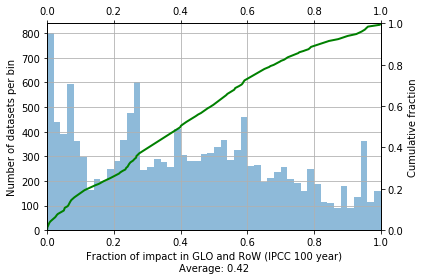

In [57]:
graph(fraction_in_global, "Fraction of impact in GLO and RoW (IPCC 100 year)")

# How much transport is in the supply chain?

In this case, we wrap all our previous work together and filter by unit.

In [58]:
def transport_specific_dataframe_by_location(activity):
    lca = bw.LCA({activity: 1})
    lca.lci()
    df = pd.DataFrame.from_dict([
            {
                'location': a['location'],
                'unit': a['unit'],
                'score': (lca.supply_array[lca.activity_dict[a]] 
                          - (1 if activity == a else 0)) # Subtract functional unit if f.u. is transport
            } 
        for a in bw.Database(activity['database']) 
        if lca.supply_array[lca.activity_dict[a]] != 0 
        and a['unit'] in ('ton kilometer', 'person kilometer')
    ])
    return {
        'ton kilometer': df[df['unit'] == 'ton kilometer'].groupby('location').sum(
            ).sort_values('score', ascending=False),
        'person kilometer': df[df['unit'] == 'person kilometer'].groupby('location').sum(
            ).sort_values('score', ascending=False)
    }

In [61]:
activity = bw.Database("ecoinvent 3.4 cutoff").random()
print(activity)
transport_specific_dataframe_by_location(activity)['ton kilometer']

'petroleum refinery operation' (kilogram, RoW, None)


,score
location,
GLO,8.929131
RoW,0.126953
RER,0.049316
US,0.012370
CN,0.010946
RU,0.002835
Europe without Switzerland,0.002253
DZ,0.000942
DE,0.000297
